In [1]:
import pandas as pd

In [ ]:
df = pd.read_csv("../data/destinations.csv")
df.head()

In [ ]:
print("Number of destinations: ", df.shape[0])
print("Number of attributes: ", df.shape[1])


In [ ]:
# City, country and continent names are not relevant for the training
city_names = df["city"].copy()
destinations = df.drop(columns=["city", "country", "continent"])
destinations

In [ ]:
destinations["climate"].unique()

In [ ]:
# One-Hot encoding
climate_dummies = pd.get_dummies(
    destinations["climate"],
    prefix="climate"
)

destinations = pd.concat([destinations.drop(columns=["climate"]), climate_dummies], axis=1)

In [ ]:
destinations.head()

In [ ]:
destinations["safety_rating"].unique()

In [ ]:
# Min-Max normalize
min_s = destinations["safety_rating"].min()
max_s = destinations["safety_rating"].max()

destinations["safety_rating"] = (destinations["safety_rating"] - min_s) / (max_s - min_s)
destinations["safety_rating"]

In [ ]:
destinations["popularity"].unique()

In [ ]:
# Min-Max normalize
min_s = destinations["popularity"].min()
max_s = destinations["popularity"].max()

destinations["popularity"] = (destinations["popularity"] - min_s) / (max_s - min_s)
destinations["popularity"]

# Training the Neural Network with training data

In [2]:
df_training = pd.read_csv("../data/training_data.csv")
df_training.shape

(5000, 33)

In [3]:
df_training.head()

,user_id,destination_id,user_age_group,user_primary_style,user_group_type,user_budget,user_climate_pref,user_safety_importance,user_popularity_pref,user_preferred_month,...,user_likes_relaxation,dest_has_adventure,dest_has_beach,dest_has_culture,dest_has_food,dest_has_nature,dest_has_nightlife,dest_has_relaxation,compatibility_score,label
0,0,14,51+,adventure,solo,high,tropical,0.581678,0.875692,Mar,...,0,0,0,1,1,0,1,0,0.535,1
1,0,80,51+,adventure,solo,high,tropical,0.581678,0.875692,Mar,...,0,1,0,1,0,1,0,0,0.611,0
2,0,46,51+,adventure,solo,high,tropical,0.581678,0.875692,Mar,...,0,0,0,1,1,0,0,0,0.525,1
3,0,24,51+,adventure,solo,high,tropical,0.581678,0.875692,Mar,...,0,0,0,1,0,0,0,0,0.617,1
4,0,42,51+,adventure,solo,high,tropical,0.581678,0.875692,Mar,...,0,0,0,1,1,0,1,0,0.506,0


In [24]:
# Checking to see if there are any missing values
df_training.isnull().sum().sum()

0

In [25]:
# Split the data for X and y (target)
drop_columns = ['user_id', 'destination_id', 'dest_city', 'dest_country', 'dest_continent', 
                'compatibility_score']

X = df_training.drop(columns=drop_columns + ['label'])
y = df_training['label']

In [27]:
unique_counts = pd.DataFrame.from_records([(col, df_training[col].nunique()) for col in df_training.columns],
                          columns=['Column_Name', 'Num_Unique']).sort_values(by=['Num_Unique'])
unique_counts

,Column_Name,Num_Unique
32,label,2
19,user_likes_culture,2
20,user_likes_food,2
21,user_likes_nature,2
22,user_likes_nightlife,2
23,user_likes_relaxation,2
24,dest_has_adventure,2
17,user_likes_adventure,2
25,dest_has_beach,2
27,dest_has_food,2


In [28]:
for col in df_training.columns:
    if df_training[col].nunique() < 29:
        df_training[col] = df_training[col].astype('category')

In [29]:
from sklearn.preprocessing import LabelEncoder

categorical_cols = X.select_dtypes(include=['object']).columns.tolist()

print(f"Categorical columns: {categorical_cols}")

label_encoders = {}

for col in categorical_cols:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])
    label_encoders[col] = le

Categorical columns: ['user_age_group', 'user_primary_style', 'user_group_type', 'user_budget', 'user_climate_pref', 'user_preferred_month', 'dest_climate']


In [30]:
from sklearn.preprocessing import StandardScaler

numerical_cols = ['user_safety_importance', 'user_popularity_pref', 'dest_cost', 
                  'dest_popularity', 'dest_safety']

print(f"Numerical columns before scaling:")
print(X[numerical_cols].describe())

# We scale AFTER splitting
scaler = StandardScaler()

Numerical columns before scaling:
       user_safety_importance  user_popularity_pref    dest_cost  \
count             5000.000000           5000.000000  5000.000000   
mean                 0.750308              0.673549  1292.270000   
std                  0.145175              0.201751   416.987437   
min                  0.500507              0.304893   650.000000   
25%                  0.630558              0.475591   950.000000   
50%                  0.757619              0.717060  1200.000000   
75%                  0.864027              0.853495  1600.000000   
max                  0.998613              0.994238  2500.000000   

       dest_popularity  dest_safety  
count      5000.000000  5000.000000  
mean          7.570200     7.608800  
std           0.854177     1.112659  
min           6.000000     5.000000  
25%           7.000000     7.000000  
50%           8.000000     8.000000  
75%           8.000000     9.000000  
max           9.000000     9.000000  


In [32]:
from sklearn.model_selection import train_test_split

X_train, X_tmp, y_train, y_tmp = train_test_split(
    X, y, 
    test_size=0.30, # 70% for training
    random_state=42,
    stratify=y
)

X_val, X_test, y_val, y_test = train_test_split(
    X_tmp, y_tmp,
    test_size=0.50,
    random_state=42,
    stratify=y_tmp
)

In [34]:
X_train.values

array([[2., 6., 1., ..., 1., 0., 0.],
       [0., 6., 2., ..., 0., 0., 0.],
       [0., 4., 3., ..., 0., 1., 0.],
       ...,
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 4., 0., ..., 0., 0., 0.],
       [3., 1., 0., ..., 0., 0., 0.]])

In [35]:
X_val.values

array([[0., 3., 3., ..., 0., 0., 0.],
       [1., 6., 2., ..., 0., 1., 0.],
       [3., 0., 0., ..., 1., 0., 0.],
       ...,
       [1., 6., 0., ..., 0., 1., 0.],
       [0., 2., 3., ..., 1., 0., 0.],
       [3., 0., 1., ..., 0., 0., 1.]])

In [36]:
num_cols_indices = [X_train.columns.get_loc(col) for col in numerical_cols]

X_train_array = X_train.values
X_val_array = X_val.values
X_test_array = X_test.values

# Fit scaling only on training data
scaler.fit(X_train_array[:, num_cols_indices])

# Apply scaling to all sets
X_train_array[:, num_cols_indices] = scaler.transform(X_train_array[:, num_cols_indices])
X_val_array[:, num_cols_indices] = scaler.transform(X_val_array[:, num_cols_indices])
X_test_array[:, num_cols_indices] = scaler.transform(X_test_array[:, num_cols_indices])


In [38]:
print(f"Numerical columns after scaling:")
print(pd.DataFrame(X_train_array[:5, num_cols_indices], columns=numerical_cols))

Numerical columns after scaling:
   user_safety_importance  user_popularity_pref  dest_cost  dest_popularity  \
0                0.293588             -0.675021   0.956504        -1.842639   
1               -1.089074              0.198038   0.005671         0.512386   
2               -1.620330              0.295443  -0.469745         0.512386   
3               -0.506666              1.456753  -0.469745         0.512386   
4               -1.697988             -0.158879   0.837649        -0.665126   

   dest_safety  
0     1.237482  
1     1.237482  
2    -2.349421  
3    -1.452696  
4     0.340756  


In [39]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

def build_model(input_dim):
    model = keras.Sequential([
        layers.Input(shape=(input_dim,)),
        
        layers.Dense(128, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        
        layers.Dense(64, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        
        layers.Dense(32, activation='relu'),
        layers.Dropout(0.2),
        
        layers.Dense(1, activation='sigmoid')
    ])
    
    return model

model = build_model(X_train_array.shape[1])

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                 │ (None, 128)            │         3,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,593 (57.00 KB)

 Trainable params: 14,209 (55.50 KB)

 Non-trainable params: 384 (1.50 KB)

In [40]:
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy', 
             keras.metrics.Precision(),
             keras.metrics.Recall()]
)

In [41]:
callbacks = [
    keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=15,
        restore_best_weights=True,
        verbose=1
    ),
    
    keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-6,
        verbose=1
    ),
    
    keras.callbacks.ModelCheckpoint(
        'best_model.keras',
        monitor='val_loss',
        save_best_only=True,
        verbose=1
    )
]

In [42]:
print("Starting training...\n")

history = model.fit(
    X_train_array, y_train.values,
    validation_data=(X_val_array, y_val.values),
    epochs=100,
    batch_size=64,
    callbacks=callbacks,
    verbose=1
)

print("\n Training complete")

Starting training...

Epoch 1/100
43/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4977 - loss: 0.8347 - precision_1: 0.5244 - recall_1: 0.4545 
Epoch 1: val_loss improved from inf to 0.67165, saving model to best_model.keras
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5026 - loss: 0.8220 - precision_1: 0.5324 - recall_1: 0.4724 - val_accuracy: 0.5947 - val_loss: 0.6716 - val_precision_1: 0.5808 - val_recall_1: 0.9091 - learning_rate: 0.0010
Epoch 2/100
41/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5803 - loss: 0.7091 - precision_1: 0.6166 - recall_1: 0.6544 
Epoch 2: val_loss improved from 0.67165 to 0.65660, saving model to best_model.keras
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5803 - loss: 0.7063 - precision_1: 0.6133 - recall_1: 0.6571 - val_accuracy: 0.6400 - val_loss: 0.6566 - val_precision_1: 0.6167 - val_recall_1: 0.8894 - learning_rate: 0.0010
Epoch 3/100
44/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5700 - loss: 0.6984 - precision_1: 

# Visualizing the fittnes function

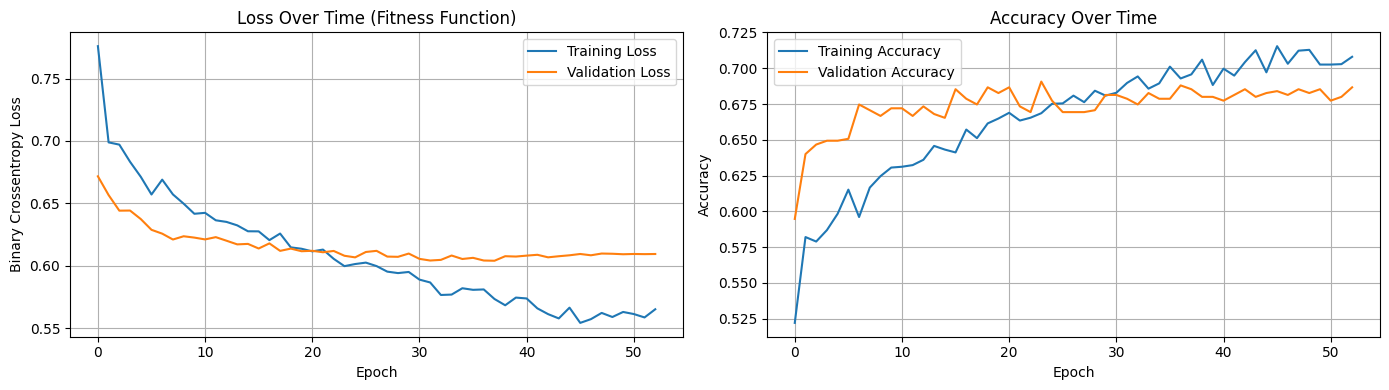

In [43]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(14, 4))

axes[0].plot(history.history['loss'], label='Training Loss')
axes[0].plot(history.history['val_loss'], label='Validation Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Binary Crossentropy Loss')
axes[0].set_title('Loss Over Time (Fitness Function)')
axes[0].legend()
axes[0].grid(True)

axes[1].plot(history.history['accuracy'], label='Training Accuracy')
axes[1].plot(history.history['val_accuracy'], label='Validation Accuracy')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Accuracy Over Time')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

In [44]:
# Evaluate on test set
test_results = model.evaluate(X_test_array, y_test.values, verbose=0)

print("="*60)
print("TEST SET PERFORMANCE")
print("="*60)
print(f"Loss: {test_results[0]:.4f}")
print(f"Accuracy: {test_results[1]:.4f} ({test_results[1]*100:.2f}%)")
print(f"Precision: {test_results[2]:.4f}")
print(f"Recall: {test_results[3]:.4f}")
print("="*60)

TEST SET PERFORMANCE
Loss: 0.6293
Accuracy: 0.6627 (66.27%)
Precision: 0.6659
Recall: 0.7562
